# Testing Spark + `sparklyr`

## Table of Contents

- [Kickstart](#Kickstart)
- [Uploading the data in JSON format](#Uploading-the-data-in-JSON-format)
- [Install libraries in SparkR](#Install-libraries-in-SparkR)
- [Spark and R in Jupyter](#Spark-and-R-in-Jupyter)
    - [Configuring Spark and R](#Configuring-Spark-and-R)
    - [Loading spark context (RDDs)](#Loading-spark-context-(RDDs)
- [Reading JSON into Spark context: `jscars.json`](#Reading-JSON-into-Spark-context:-jscars.json)
    - [Basic data wrangling](#Basic-data-wrangling)
    - [Graphs](#Graphs)
    - [Models: K-means](#Models:-K-means)
- [Session](#Session)
    - [Paths recognised by sparkR](#Paths-recognised-by-sparkR)
    - [R session info](#R-session-info)
- [References](#References)

## Kickstart

See the [pyspark course](https://github.com/javicacheiro/pyspark_course/blob/master/unit_1_tools.ipynb) here.

## Uploading the data in JSON format 

First, we need to upload our data from our HOME to the HDFS home directory.  
- You can add a single file, or an entire folder.
- You can also list or delete files, folders.

    $ hdfs dfs -put /mnt/gluster/...../data/jscars.json .
      # list data
      hdfs dfs -ls
      # deleting files, folders
      hdfs dfs -rm -r -f data/jscars.json

## Install libraries in SparkR

Before all, enter `sparkR` from your HOME directory:

    $ sparkR

Then, install the libraries as needed. When you finish, exit the interactive `sparkR` session.

    > install.packages(c("sparklyr", "dplyr", "knitr", "ggplot2", "repr")
    > q()

## Spark and R in Jupyter

### Configuring Spark and R 

Add this variable to .bashrc to avoid setting `Sys.setenv` in `R`.

    $ cd $HOME
      export R_PROFILE_USER=/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R
      source .bashrc

Set `R` environment variables (needed for Jupyter notebooks in the cluster `sparkR` installation).

In [2]:
# Sys.setenv(SPARK_HOME='/usr/hdp/2.4.2.0-258/spark') # commented after being added to .bashrc
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

Load libraries:

In [4]:
x <- c("sparklyr", "dplyr", "knitr", "ggplot2", "repr")
lapply(x, require, character.only = TRUE, quietly = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

### Loading spark context (RDDs)

Currently there are three types of contexts:

- Local context: 
    - Interactive. 
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - All processes reside in the LOGIN node (drivers and executors).
    - Can only be used for tasks that require very few resources.
- YARN-client: 
    - Interactive.
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - The driver resides in the LOGIN node, but the executors are in the CLUSTER nodes. Thus, executors can use all the memory available for the task in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
- YARN-cluster:
    - Not interactive.
    - Both the driver and the executors reside in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
    - Currenty doesn't seem available for this version of `R/sparklyr`.
    
Defining a new context (`sc`) overwrites the previous one.

In [5]:
# Initiating spark context: local (for 'low memory' tasks only!)
sc <- spark_connect(master = "local", spark_home = "/usr/hdp/2.4.2.0-258/spark")

# Initiating spark context: yarn (for loading bigger datasets)
sc <- spark_connect(master = "yarn-client", spark_home = "/usr/hdp/2.4.2.0-258/spark")

## Reading JSON into Spark context: `jscars.json`

The data `jscars.json` is the `mtcars` dataset saved in a JSON format.

In [6]:
jscars <- spark_read_json(sc, name = "jscars", path = "amazon/jscars.json")
# books <- spark_read_json(sc, name = "books", path = "amazon/reviews_Books_5.json") # very big dataset

In [7]:
jscars %>%
  head(6) %>%
  collect()

am,carb,cyl,disp,drat,gear,hp,mpg,qsec,vs,wt
1,4,6,160,3.90,4,110,21.0,16.46,0,2.620
1,4,6,160,3.90,4,110,21.0,17.02,0,2.875
1,1,4,108,3.85,4,93,22.8,18.61,1,2.320
0,1,6,258,3.08,3,110,21.4,19.44,1,3.215
0,2,8,360,3.15,3,175,18.7,17.02,0,3.440


### Basic data wrangling

We can make good use of `magrittr::%>%` *pipes* for data wrangling or window operations:  
The `warnings` issued here are usually not important. They depend on the `sparklyr` version. See [here](https://github.com/rstudio/sparklyr/issues/426) for more info.

In [10]:
jscars %>%
  group_by(vs) %>%
  filter(gear == 3, hp > 100) %>%
  mutate(horsepower_by_gear = rank(desc(hp / gear))) %>%
  mutate(mpg_rank = rank(mpg)) %>%
  select(gear, mpg_rank, horsepower_by_gear) %>% 
  head(6) %>%
  collect()

vs,gear,mpg_rank,horsepower_by_gear
0,3,1,4
0,3,1,5
0,3,3,1
0,3,4,1
0,3,5,3
0,3,6,6


We can disable this warning with:

In [9]:
options(warn = -1)

### Graphs 

`geom_smooth()` using method = 'loess'


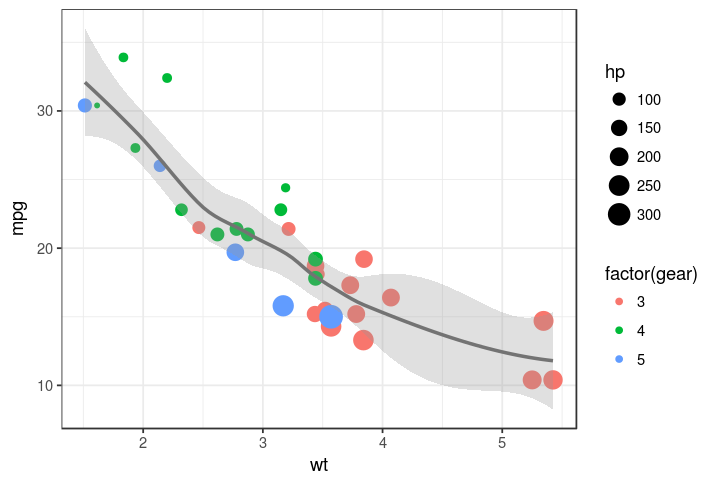

In [14]:
options(repr.plot.width=6, repr.plot.height=4)

jscars %>%
  collect() %>%
    ggplot(aes(wt, mpg)) +
    geom_point(aes(colour=factor(gear), size=hp)) + 
    geom_smooth(colour="#737373", alpha=0.3) + 
    theme_bw()

### Models: K-means 

In [16]:
kmeans_model <- jscars %>%
  select(wt, mpg) %>%
  ml_kmeans(centers = 3)

print(kmeans_model)

* No rows dropped by 'na.omit' call


K-means clustering with 3 clusters

Cluster centers:
        wt      mpg
1 3.971714 14.95714
2 1.819600 30.88000
3 2.942308 21.46923

Within Set Sum of Squared Errors =  161.3099

In [17]:
# predict the associated class
predicts <- sdf_predict(kmeans_model, jscars) 
predicted <- collect(predicts)
collect(head(predicted))
base::table(predicted$am, predicted$prediction)

am,carb,cyl,disp,drat,gear,hp,mpg,qsec,vs,wt,prediction
1,4,6,160,3.90,4,110,21.0,16.46,0,2.620,2
1,4,6,160,3.90,4,110,21.0,17.02,0,2.875,2
1,1,4,108,3.85,4,93,22.8,18.61,1,2.320,2
0,1,6,258,3.08,3,110,21.4,19.44,1,3.215,2
0,2,8,360,3.15,3,175,18.7,17.02,0,3.440,2
0,1,6,225,2.76,3,105,18.1,20.22,1,3.460,0


   
     0  1  2
  0 12  0  7
  1  2  5  6

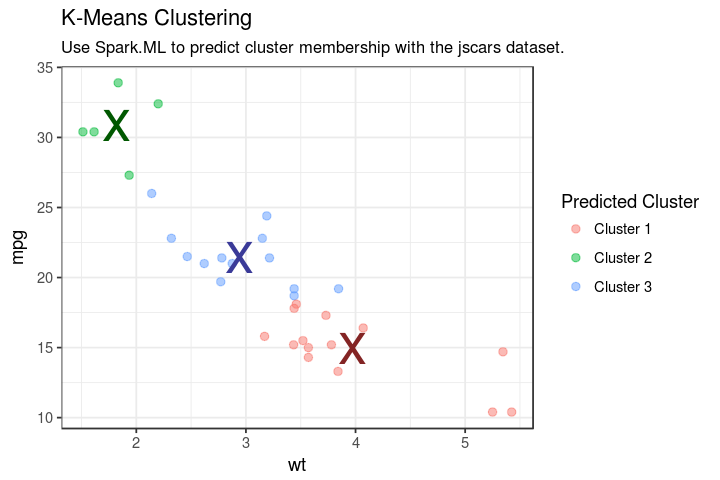

In [25]:
# plot cluster membership
sdf_predict(kmeans_model) %>%
  collect() %>%
  ggplot(aes(wt, mpg)) +
    geom_point(aes(wt, mpg, col = factor(prediction + 1)),
               size = 2, alpha = 0.5) + 
    geom_point(data = kmeans_model$centers, aes(wt, mpg),
               col = scales::muted(c("red", "green", "blue")),
               pch = 'x', size = 12) +
    scale_color_discrete(name = "Predicted Cluster",
                         labels = paste("Cluster", 1:3)) +
    labs(
      x = "wt",
      y = "mpg",
      title = "K-Means Clustering",
      subtitle = "Use Spark.ML to predict cluster membership with the jscars dataset."
    ) +
    theme_bw()

## Session 

### Paths recognised by sparkR 

In [29]:
.libPaths()
Sys.getenv("R_HOME")

### R session info

In [30]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

locale:
 [1] LC_CTYPE=es_ES.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=es_ES.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=es_ES.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] repr_0.10      ggplot2_2.2.0  knitr_1.15.1   dplyr_0.7.1    sparklyr_0.5.6
[6] SparkR_1.6.1  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8      plyr_1.8.4       highr_0.6        dbplyr_1.1.0    
 [5] bindr_0.1        base64enc_0.1-3  tools_3.3.2      digest_0.6.10   
 [9] uuid_0.1-2       gtable_0.2.0     jsonlite_1.1     evaluate_0.10   
[13] tibble_1.3.3     pkgconfig_2.0.1  rlang_0

## References 

- [`sparklyr` tutorial](http://spark.rstudio.com/).
- [`sparklyr` cheatsheet](http://spark.rstudio.com/images/sparklyr-cheatsheet.pdf).
- [`sparklyr`: creating extensions](http://spark.rstudio.com/extensions.html).
- [Differences between `sparkr` and `sparklyr`](https://stackoverflow.com/questions/39494484/sparkr-vs-sparklyr)..
- [Hive Operators and UDFs](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF).